In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%load_ext autoreload
%autoreload 2

import IPython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
data_folder = '../output-explore-infl-logreg/'
data_filename = 'explore-infl-logreg-data-hospital-prop-0.1-subsets-5-subset_seed-13-center-data-False.npz'
f = np.load(os.path.join(data_folder, data_filename))

initial_train_losses = f['initial_train_losses']
initial_test_losses = f['initial_test_losses']
initial_train_margins = f['initial_train_margins']
initial_test_margins = f['initial_test_margins']
grad_loss = f['grad_loss']
test_points = f['test_points']
fixed_test_pred_infl = f['fixed_test_pred_infl']
fixed_test_pred_margin_infl = f['fixed_test_pred_margin_infl']
subset_tags = f['subset_tags']
subset_indices = f['subset_indices']
subset_train_losses = f['subset_train_losses']
subset_test_losses = f['subset_test_losses']
subset_train_margins = f['subset_train_margins']
subset_test_margins = f['subset_test_margins']
subset_self_influences = f['subset_self_influences']

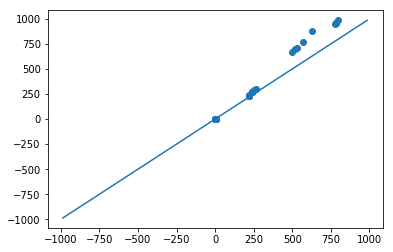

In [10]:
subset_initial_losses = np.array([np.sum(initial_train_losses[s]) for s in subset_indices])
subset_retrained_losses = np.array([np.sum(train_losses[s])
                                    for s, train_losses in zip(subset_indices, subset_train_losses)])
subset_actl_infl = subset_retrained_losses - subset_initial_losses
subset_pred_infl = subset_self_influences

W = max(np.max(np.abs(subset_actl_infl)), np.max(np.abs(subset_pred_infl)))
plt.scatter(subset_actl_infl, subset_pred_infl)
plt.plot([-W, W], [-W, W])

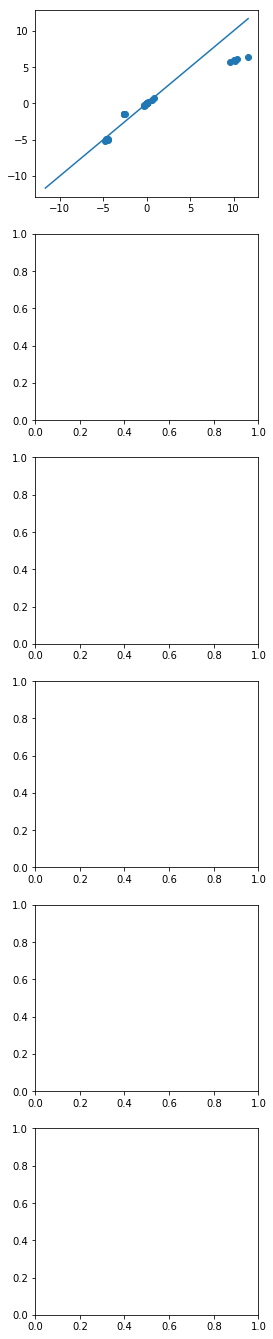

In [14]:
fig, axs = plt.subplots(len(test_points), 1, figsize=(4, 4 * len(test_points)), squeeze=False)

for i, test_idx in enumerate(test_points):
    if i > 0: break
    subset_initial_losses = np.array([initial_test_losses[test_idx] for s in subset_indices])
    subset_retrained_losses = np.array([test_losses[test_idx] for test_losses in subset_test_losses])
    subset_actl_infl = subset_retrained_losses - subset_initial_losses
    subset_pred_infl = np.array([np.sum(fixed_test_pred_infl[i][s]) for s in subset_indices])

    W = max(np.max(np.abs(subset_actl_infl)), np.max(np.abs(subset_pred_infl)))
    axs[i][0].scatter(subset_actl_infl, subset_pred_infl)
    axs[i][0].plot([-W, W], [-W, W])